## Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: It's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

In [3]:
# library imports
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, root_mean_squared_error, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [5]:
df = pd.read_csv('chronic_kidney_disease_full.csv')
df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47.0,6700.0,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54.0,7800.0,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49.0,6600.0,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51.0,7200.0,5.9,no,no,no,good,no,no,notckd


In [6]:
# review datatype
df.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
class     object
dtype: object

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

<Axes: >

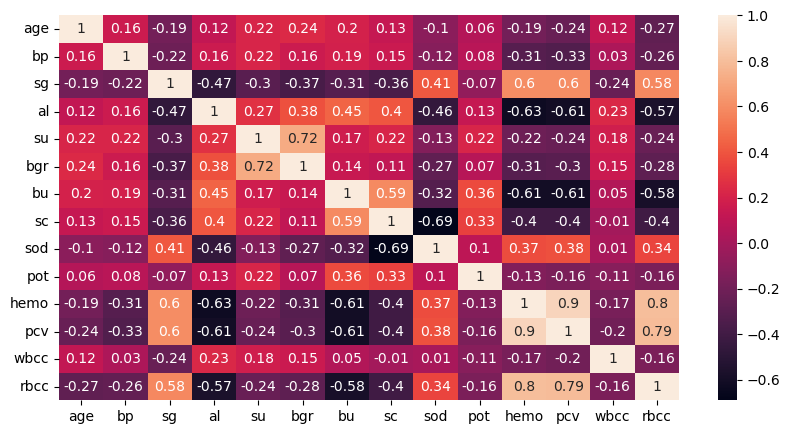

In [8]:
features = [n for n, t in df.dtypes.items() if 'float' in str(t)]
plt.figure(figsize=(10,5))
sns.heatmap(df[features].corr().round(2), annot=True)

- Sodium

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [11]:
# calculate % of null rows in each columns
df.isnull().agg(['sum','mean']).rename(columns={'sum':'num', 'mean':'pct'}).T

,sum,mean
age,9.0,0.0225
bp,12.0,0.0300
sg,47.0,0.1175
al,46.0,0.1150
su,49.0,0.1225
rbc,152.0,0.3800
pc,65.0,0.1625
pcc,4.0,0.0100
ba,4.0,0.0100
bgr,44.0,0.1100


In [12]:
df.groupby('rbc')['class'].count()

rbc
abnormal     47
normal      201
Name: class, dtype: int64

In [13]:
# since null value is more than half of each class, 
df.drop('rbc', axis=1, inplace=True)

##### Cleanup Data

In [15]:
# impute columns with object datatype with mode values
for col in df.select_dtypes(include='object').columns:
    df.loc[:, col] = df[col].fillna(df[col].mode().iloc(0))

In [16]:
# impute columns with float datatype with median values
for col in df.select_dtypes(include='float').columns:
    df.loc[:, col] = df[col].fillna(df[col].median())

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

In [18]:
# remain rows 158 rows
comp_case_df = df.dropna()
comp_case_df.shape

(400, 24)

- By discarding rows with missing values, you lose valuable information that could be relevant to your analysis.
- If the missingness of data is not random, then discarding incomplete cases can introduce bias into your analysis.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

- Medical measurements, such as blood pressure or lab tests result, can be subject to measurement error.
- Patients may forget or misremember details, leading to inaccurate data entry.
- A doctor's preconceived notions can influence symptom recording.

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has chronic kidney disease (CKD) will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Simply always predict "CKD" for every individual

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

- We are optimizing for sensitivity.
- Minimize false negative.

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

It dramatically increases the number of false positives. This means many people who do not have CKD will be incorrectly diagnosed and may undergo unnecessary tests, treatments, or experience unnecessary anxiety.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Simply always predict "no CKD" for every individual.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

- We are optimizing for specificity.
- Minimize false positive.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

This means many people who actually have CKD will be misclassified as not having it, potentially delaying necessary treatment and leading to health outcomes.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [35]:
# 'rbc',
dummy_comp_case_df = pd.get_dummies(columns=['pc','pcc','ba','htn','dm','cad','appet','pe','ane'], data=df, drop_first=True)
dummy_comp_case_df.shape
#dummy_comp_case_df.head(2)
dummy_comp_case_df['class'] = dummy_comp_case_df['class'].apply(lambda a: 1 if a == 'ckd' else 0)
dummy_comp_case_df.dtypes

age               float64
bp                float64
sg                float64
al                float64
su                float64
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv               float64
wbcc              float64
rbcc              float64
class               int64
pc_abnormal          bool
pc_normal            bool
pcc_notpresent       bool
pcc_present          bool
ba_notpresent        bool
ba_present           bool
htn_no               bool
htn_yes              bool
dm_no                bool
dm_yes               bool
cad_no               bool
cad_yes              bool
appet_good           bool
appet_poor           bool
pe_no                bool
pe_yes               bool
ane_no               bool
ane_yes              bool
dtype: object

In [36]:
dummy_comp_case_df['class'].value_counts()

class
1    250
0    150
Name: count, dtype: int64

In [37]:
# calculate baseline
dummy_comp_case_df['class'].value_counts(normalize=True).mul(100).round(2)

class
1    62.5
0    37.5
Name: proportion, dtype: float64

In [38]:
# select training data
features = [n for n in dummy_comp_case_df.columns if n != 'class']
X = dummy_comp_case_df[features]
y = dummy_comp_case_df['class']

In [39]:
# split train / test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, stratify=y)

In [40]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [41]:
lgr = LogisticRegression(penalty='l2', solver='liblinear')
lgr.fit(X_train_sc, y_train)
y_pred = lgr.predict(X_test_sc)

print(f"Cross Varidation Score: {cross_val_score(lgr, X_train_sc, y_train, cv=5).mean():.8f}")
print(f"Score of LogisticRegression for training: {lgr.score(X_train_sc, y_train):.8f}")
print(f"Score of LogisticRegression for testing: {lgr.score(X_test_sc, y_test):.8f}")

Cross Varidation Score: 0.98437500
Score of LogisticRegression for training: 0.99687500
Score of LogisticRegression for testing: 0.95000000


---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [43]:
X.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo',
       'pcv', 'wbcc', 'rbcc', 'pc_abnormal', 'pc_normal', 'pcc_notpresent',
       'pcc_present', 'ba_notpresent', 'ba_present', 'htn_no', 'htn_yes',
       'dm_no', 'dm_yes', 'cad_no', 'cad_yes', 'appet_good', 'appet_poor',
       'pe_no', 'pe_yes', 'ane_no', 'ane_yes'],
      dtype='object')

In [44]:
lgr.coef_

array([[-0.27631303,  0.56294133, -1.64436785,  0.86559286,  0.56211067,
         0.3658825 , -0.29463838,  0.7060511 , -0.16600874, -0.14825754,
        -1.58800872, -1.179107  , -0.11547349, -0.60434086, -0.09003828,
        -0.64810208,  0.12593117,  0.0842682 ,  0.19596703,  0.07808355,
        -0.4452498 ,  0.49489302, -0.40179017,  0.45352673,  0.36582242,
        -0.29261571, -0.45857856,  0.56110041, -0.00278063,  0.10512592,
         0.21852967, -0.11087665]])

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

We explain of dummy column appet_good. It coefficient is 0.56, it means that, holding all other factors constant, htn_yes are appriximately e^0.56= 1.75 times more likely to have positive outcome.

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

- Models produce coefficients that are relatively easy to interpret
- Computationally efficient, especially compared to more complex models like neural networks or decision trees
- Robust to outliers, as the logit transformation can mitigate their impact

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why?

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [50]:
# Yes it make send to generate confusion matrix as we have both y predicted and y test

cm = confusion_matrix(y_test, y_pred)
cm

array([[30,  0],
       [ 4, 46]], dtype=int64)

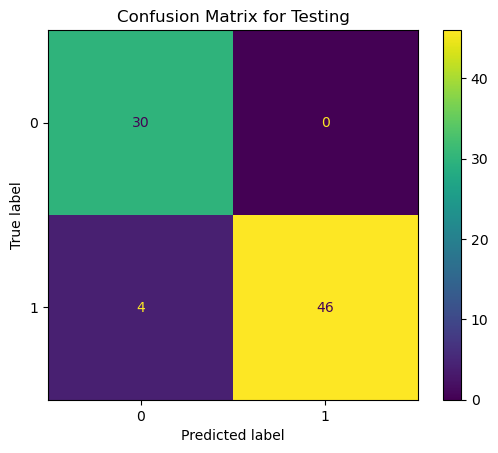

In [51]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgr.classes_).plot()
plt.title('Confusion Matrix for Testing');

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

- We must optimize for sensitivity to prioritize early detection
- A high sensitivity ensures that fewer patients with CKD are missed, reducing the risk of delayed diagnosis and treatment

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

In [55]:
def plot_roc(y_true, y_pred, y_probs):
    thresholds = np.arange(0, 1.01, 0.01)
    sensitivity = []
    specificity = []

    # Calculate sensitivity and specificity for each threshold
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        sensitivity.append(tp / (tp + fn))
        specificity.append(tn / (tn + fp))

    # Convert specificity to 1 - specificity
    false_positive_rate = [1 - spec for spec in specificity]

    plt.figure(figsize=(10, 6))
    plt.plot(false_positive_rate, sensitivity, color = 'blue')
    plt.plot([0, 1], [0, 1], color = 'red', linestyle = '--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid()
    plt.show()

y_pred_proba = lgr.predict_proba(X_test_sc)
#plot_roc(y_test, y_pred, y_pred_proba[:, 1])

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

CKD patients are a small minority, the model might simply predict 'non CKD' for most instances, achieving high overall accuracy but failing to identify many actual cases.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

It's like diagnosing a rare disease. Let's say only 1 in 1000 patients actually have this disease. If you simply guess that every patient doesn't have the disease, you'll be right 999 times out of 1000. But you'll miss every single patient who does have the disease.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [61]:
features = [n for n in dummy_comp_case_df.columns if n != 'class']
X = dummy_comp_case_df[features]
y = dummy_comp_case_df['class']

In [62]:
dummy_comp_case_df.dtypes
dummy_comp_case_bs_df = pd.concat([dummy_comp_case_df[dummy_comp_case_df['class']==0], \
                        dummy_comp_case_df[dummy_comp_case_df['class']==1].sample(n=200_000, replace=True, random_state=42)]).sort_index()
dummy_comp_case_bs_df.shape

(200150, 33)

In [63]:
dummy_comp_case_bs_df['class'].value_counts(normalize=True).mul(100)

class
1    99.925056
0     0.074944
Name: proportion, dtype: float64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [65]:
# select training data
features = [n for n in dummy_comp_case_df.columns if n != 'class']
X = dummy_comp_case_bs_df[features]
y = dummy_comp_case_bs_df['class']

# split train / test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, stratify=y)

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

lgr = LogisticRegression(penalty='l2', solver='liblinear')
lgr.fit(X_train_sc, y_train)
y_pred = lgr.predict(X_test_sc)

print(f"Cross Varidation Score: {cross_val_score(lgr, X_train_sc, y_train, cv=5).mean():.8f}")
print(f"Score of LogisticRegression for training: {lgr.score(X_train_sc, y_train):.8f}")
print(f"Score of LogisticRegression for testing: {lgr.score(X_test_sc, y_test):.8f}")

Cross Varidation Score: 0.99987509
Score of LogisticRegression for training: 0.99990007
Score of LogisticRegression for testing: 0.99982513


---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!